<a href="https://colab.research.google.com/github/paulgureghian/CNN_in_TensorFlow_Keras/blob/master/CNN_in_TF_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convolutional Neural Networks

In this notebook, I will build and train a convolutional neural network to classify images of clothing, like sneakers and shirts.

I will use TensorFlow and Keras. 

## Install and import packages



In [0]:
### Install TensorFlow datasets
!pip install -q -U tensorflow_datasets

In [0]:
### Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

### Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

### Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

tf.enable_eager_execution()  

## Import the Fashion MNIST dataset

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>


I will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. 

In [0]:
### Import the MNIST Fashion dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [0]:
### Store the class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. 

The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [38]:
### Print the number of 'train' and 'test' examples
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. 

For the model to work properly, these values need to be normalized to the range `[0,1]`. 

So here I create a normalization function, and then apply it to each image in the test and train datasets.

In [0]:
### Define the 'normalize' function
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

### The map function applies the normalize function to each element in the train
### and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

### Explore the processed data

Let's plot an image to see what it looks like.

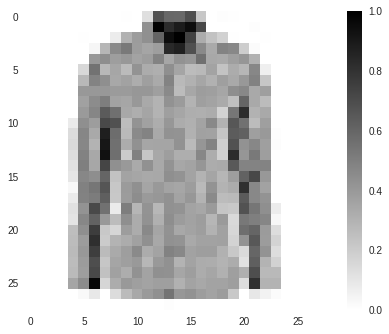

In [40]:
### Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

### Plot the image 
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. 

Verify that the data is in the correct format and I am ready to build and train the network.

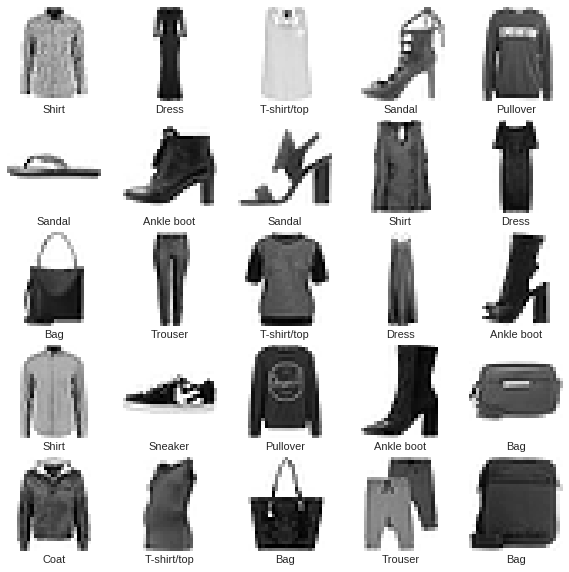

In [41]:
### Display the first 25 imgaes in the train set
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the Convolutional Neural Network requires configuring the layers of the model, then compiling the model.

### Setup the network

The basic building block of a convolutional neural network is the *layer*. A layer extracts a representation from the data fed into it. 

Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [0]:
### Define the model network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)])

The network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D` — The Network starts with two pairs of Conv/MaxPool. The first layer is a Conv2D filter (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D layer also has a (3,3) kernel, which takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. 


* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by a 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is to measure the loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
### Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, I define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so the model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [0]:
### Set the 'BATCH SIZE' training param
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [45]:
### Train the model
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3946 - acc: 0.8575
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2530 - acc: 0.9074
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2094 - acc: 0.9237
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1810 - acc: 0.9327
Epoch 5/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1498 - acc: 0.9447
Epoch 6/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1291 - acc: 0.9510
Epoch 7/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1065 - acc: 0.9613
Epoch 8/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0929 - acc: 0.9656
Epoch 9/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0755 - acc: 0.9720
Epoch 10/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0636 - acc: 0.9765


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Compare how the model performs on the test dataset. 

Use all examples in the test dataset to assess accuracy.

In [46]:
### Get the model accuracy
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 4s 13ms/step - loss: 0.3194 - acc: 0.9190
Accuracy on test dataset: 0.919


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. 

This is completely normal, since the model was trained on the `train_dataset`. 

When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, I can use it to make predictions about some images.

In [0]:
### Get predictions on one batch from the test set 
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [48]:
### Shape of the predictions
predictions.shape

(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [49]:
### Probabilities for the the first image
predictions[0]

array([5.7781762e-09, 7.8761867e-12, 7.8029982e-05, 4.5005272e-06,
       2.1695483e-01, 3.5201786e-08, 7.8296185e-01, 7.3657947e-07,
       2.8452454e-09, 3.0301475e-08], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [50]:
### Get the highest probability
np.argmax(predictions[0])

6

So the model is most confident that this image is a shirt, or `class_names[6]`. And we can check the test label to see this is correct:

In [51]:
### Check the test label
test_labels[0]

6

We can graph this to look at the full set of 10 channels

In [0]:
### Define 'plot image' function
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

### Define 'plot value array' function 
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

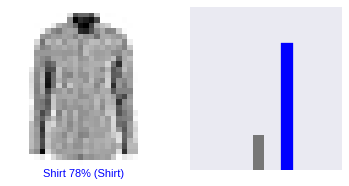

In [53]:
### Display the first image
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

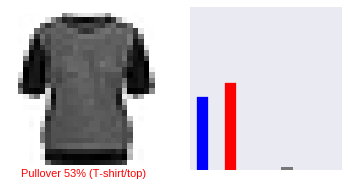

In [54]:
### Display the image 
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Let's plot several images with their predictions. 

Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label.  

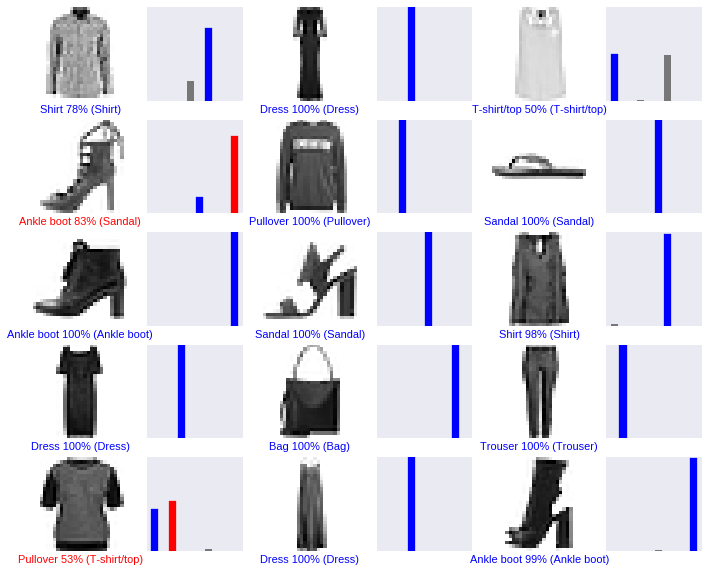

In [55]:
### Plot the first X test images, their predicted label, and the true label
### Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [56]:
### Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. 

So even though I am using a single image, I need to add it to a list:

In [57]:
### Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [58]:
### Get a prediction
predictions_single = model.predict(img)

print(predictions_single)

[[5.7781970e-09 7.8761997e-12 7.8030193e-05 4.5005436e-06 2.1695498e-01
  3.5201715e-08 7.8296173e-01 7.3658214e-07 2.8452556e-09 3.0301646e-08]]


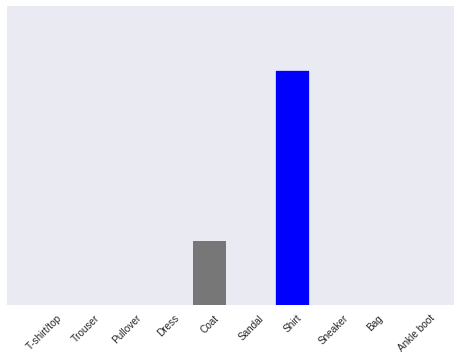

In [59]:
### Plot the prediction probability 
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. 

Grab the predictions for our (only) image in the batch:

In [60]:
### Get highest probability
np.argmax(predictions_single[0])

6

And, as before, the model predicts a label of 6 (shirt).